In [63]:
import numpy as np
import itertools
from pprint import pprint
from tqdm.notebook import tqdm
import matplotlib.pylab as plt

In [2]:
c = 3

In [3]:
# Generate some data
np.random.seed(42)
lambda1 = np.random.normal(size=(c, c))
lambda2 = np.random.normal(size=(c, c))
lambda3 = np.random.normal(size=(c, c))
G1 = np.random.normal(size=(c, c, c))
G2 = np.random.normal(size=(c, c, c))
U = np.random.normal(size=(c, c, c, c))

In [20]:
def Z_naive(lambda1, lambda2, lambda3, G1, G2, U):
    c = lambda1.shape[0]
    Z = np.zeros(shape=(c, c, c, c))
    for a, b, c, d, e, f, g, h, i, j in itertools.product(*([range(c)]*10)):
        Z[a, h, i, j] += lambda1[a, b]*lambda2[d, e]*lambda3[g, h]*G1[c, b, d]*G2[f, e, g]*U[i, j, c, f]
    return Z

In [21]:
%%timeit
Z = Z_naive(lambda1, lambda2, lambda3, G1, G2, U)

104 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
Z = Z_naive(lambda1, lambda2, lambda3, G1, G2, U)

In [17]:
%%timeit
Z=np.einsum('ab, cbd, de, feg, gh, ijcf -> ahij',
            lambda1, G1, lambda2, G2, lambda3, U,
            optimize= 'greedy')

431 µs ± 55.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
pprint(np.einsum_path('ab, cbd, de, feg, gh, ijcf -> ahij',
                         lambda1, G1, lambda2, G2, lambda3, U,
                         optimize= 'greedy')[1])

('  Complete contraction:  ab,cbd,de,feg,gh,ijcf->ahij\n'
 '         Naive scaling:  10\n'
 '     Optimized scaling:  6\n'
 '      Naive FLOP count:  3.543e+05\n'
 '  Optimized FLOP count:  2.431e+03\n'
 '   Theoretical speedup:  145.740\n'
 '  Largest intermediate:  8.100e+01 elements\n'
 '--------------------------------------------------------------------------\n'
 'scaling                  current                                remaining\n'
 '--------------------------------------------------------------------------\n'
 '   4                 cbd,ab->acd                 de,feg,gh,ijcf,acd->ahij\n'
 '   4                 feg,de->dfg                    gh,ijcf,acd,dfg->ahij\n'
 '   4                 dfg,gh->dfh                       ijcf,acd,dfh->ahij\n'
 '   5               dfh,acd->acfh                          ijcf,acfh->ahij\n'
 '   6             acfh,ijcf->ahij                               ahij->ahij')


In [39]:
_res = np.einsum_path('ab, cbd, de, feg, gh, ijcf -> ahij',
                         lambda1, G1, lambda2, G2, lambda3, U,
                         optimize= 'greedy')[1]
print("Optimized result: ", list(filter(lambda x: 'Optimized FLOP count' in x ,_res.split('\n')))[0].split(':')[-1])

Optimized result:    2.431e+03


### Elementary functions

In [40]:
def _self_made(_lambda1=lambda1, _lambda2=lambda2, _lambda3=lambda3,
      _G1=G1, _G2=G2, _U=U):
    _d1 = np.tensordot(_lambda1, _G1, (1, 1)) # acd
    _d2 = np.tensordot(_lambda2, _G2, (1, 1)) # dfg
    _d3 = np.tensordot(_d2, _lambda3, 1) # dfh
    _d4 = np.tensordot(_d1, _d3, 1) # acfh
    _d5 = np.tensordot(_d4, _U, ((1, 2), (2, 3)))
    return _d5

assert np.isclose(_self_made(), Z).all()

In [45]:
%%timeit
_self_made()

96.5 µs ± 8.44 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [60]:
einsum = lambda _lambda1, _lambda2, _lambda3, _G1, _G2, _U: np.einsum('ab, cbd, de, feg, gh, ijcf -> ahij',
            _lambda1, _G1, _lambda2, _G2, _lambda3, _U,
            optimize= 'greedy')

def speed_calculation(number):
    np.random.seed(42)
    check_lambda1 = np.random.normal(size=(number, number))
    check_lambda2 = np.random.normal(size=(number, number))
    check_lambda3 = np.random.normal(size=(number, number))
    check_G1 = np.random.normal(size=(number, number, number))
    check_G2 = np.random.normal(size=(number, number, number))
    check_U = np.random.normal(size=(number, number, number, number))
    self_time = %timeit -r2 -n 10 -o _self_made(check_lambda1, check_lambda2, check_lambda3, check_G1, check_G2, check_U)
    # Ждать не хочется. Так что строчка закомментирована
    # naive_time = %timeit -r2 -n 10 -o Z_naive(check_lambda1, check_lambda2, check_lambda3, check_G1, check_G2, check_U)
    naive_time = 0
    einsum_time = %timeit -r2 -n 10 -o einsum(check_lambda1, check_lambda2, check_lambda3, check_G1, check_G2, check_U)
    return [number, naive_time, einsum_time, self_time]

In [62]:
res = []
for num in tqdm(range(3, 50)):
    res.append(speed_calculation(num))

  0%|          | 0/47 [00:00<?, ?it/s]

199 µs ± 29.5 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
886 µs ± 152 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
241 µs ± 67.2 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
855 µs ± 306 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
190 µs ± 1.02 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
369 µs ± 4.37 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
107 µs ± 11.2 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
416 µs ± 22.4 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
165 µs ± 42.4 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
399 µs ± 11.7 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
132 µs ± 8.89 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
384 µs ± 1.87 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
185 µs ± 1.46 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
473 µs ± 67.4 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
176 µs ± 18.1 µs per l

In [72]:
res[0][3]

<TimeitResult : 199 µs ± 29.5 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)>

In [80]:
res[0][3].timings[1]

0.00016927419928833843

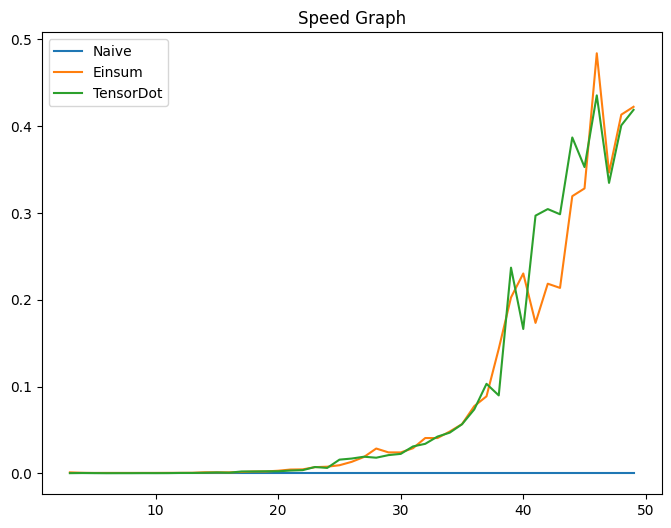

In [81]:
plt.figure(figsize=(8, 6))
plt.title("Speed Graph")
plt.plot([_[0] for _ in res], [_[1] for _ in res], label='Naive')
plt.plot([_[0]for _ in res], [_[2].timings[0] for _ in res], label='Einsum')
plt.plot([_[0]for _ in res], [_[3].timings[0] for _ in res], label='TensorDot')
plt.legend(loc='upper left')
plt.show()

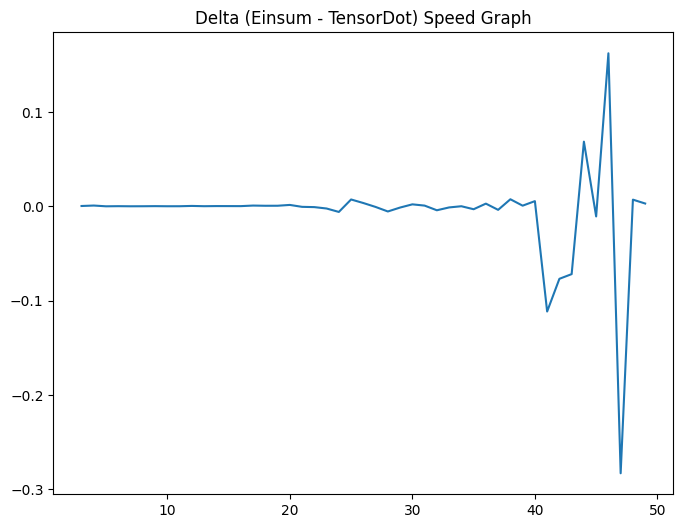

In [82]:
plt.figure(figsize=(8, 6))
plt.title("Delta (Einsum - TensorDot) Speed Graph")
plt.plot([_[0]for _ in res], [_[2].timings[0] - _[3].timings[0] for _ in res], label='Einsum')
plt.show()